# Assignment 3: Evaluating Classification Models

Use three binary explanatory variables relating to client banking history: default, housing, and loan. Predict the binary response variable: Has the client subscribed to a term deposit? Use all banking client observations with complete data for these study variables. Employ two classification methods: (1) logistic regression as described in Chapter 4 of the Géron (2017) textbook and (2) naïve Bayes classification. Evaluate these methods within a cross-validation design, using the area under the receiver operating characteristic (ROC) curve as an index of classification performance. Python scikit-learn should be your primary environment for conducting this research.

## Management Problem

Regarding the management problem, imagine that you are advising the bank about machine learning methods to guide telephone marketing campaigns: 
- Which of the two modeling methods would you recommend and why? 
- And, given the results of your research, which group of banking clients appears to be the best target for direct marketing efforts (similar to those used with previous telephone campaigns)? 


##  Deilverables and Definition
    1) Use three binary explanatory variables (default, housing, loan). Predict subscription status (response) 

# Discussion

At the request of the client we performed analysis on demographics of customers which had subscribed to a term deposit account following approaches by marketing. The data provided contains demogrphic information (mariage status, job title, age, etc) as well as present and historical data associated with their status with the bank (balance, default, and previous marketing interactions). At the behest of the client we evaluated several features to describe the likelihood of a client to subscribe to a term deposit. The features of interest identified by the client were 'default' on credit, whether the customer has a home loan ('housing'), and whether the customer has a personal loan ('loan'). We understand the client's focus on these features and their concern for the financial health of the customer. Two classifiers were evaluated using the area under the curve (AUC) of the receiver operator characteristic (ROC) through 8-fold cross-validation. The imbalance in the data lead us to stratify the observations such that the relative proportions of the minority class (the customers who eventually subscribe to the account) were not over/under represented in the training or test data. It was found that the naive bayes classifier and logistic classifer exhibited very minimal difference, naive bayes classifere slightly outperformed the logistic in the crossvalidation AUC scores. 

ROC curves and auc scores are avaialble for evaluation in section C1 for the logistic classifier and section C2 for the naive bayes classifier. It is our recommendation that the client also consider the precision recall curves made avaialble as well in each respective section from which we can judge the frequency of predicting the minority class correctly in a more direct manner. Confusion matricies are also provided in the aforementioned sections the results are normalized for eacy class such that one can judge driectly the prediction accuracy directly.

Due to the results of these modeling efforts, as evidenced in the precision recall curves; our percision for class 1 (those who opt to subscribe) drops precipitously as we adjust our ability to discern between those who do not subscribe and those who do. As such we would urge the client to consider additional/ alternative features if the sole objective is to achieve additional subscriptions. Care should be taken to consider risk from default on outstanding balances on other liens in place, however, we can vastly improve our ability to correctly identify customers who are more likely to commit to subsciptions. These experiments are outlined in section D. It should be noted that not included in this model is 'default' as the likelihood for subscribing was equally split between those with current defaults and those without. Identical methdologies as described above were used and presented herein. Addtionally section E outlines the implementation of this expanded model amongst the customers whom were contacted via phone; as is the intent for the client with this campaign. Removing observations with unknown contact method seemingly improves the successful identification of individuals who are likely to subscribe. However, observations are dropped from the model to accomplish this analysis, it is the opinion that these alternative features should generalize.

Contingency tables are provided in addition within section C, D, E that detail the number of customers by segment which choose to subscribe or not. These tables can be used to infer relative proportions of the segments which subscribe to the term deposit accounts. 

## Recommendations


### Scenario 1 (default, housing, and loan features): 
The customer segment with the highest proportion of subscription is those which have defaulted and currently hold no personal or home loans. Nearly 30% of these customers ended up subscribing. However, it is likely that this group is very small in number. As such the segment of customers which had the highest number of subscriptions were customers which did not default, nor did they have personal or home loans. This is likely a much larger segment of the bank's customers. Of the three features modeled housing and loan segments appear more impactful; customers with loans appear less likely to subscribe.

### Scenario 2 (housing, loan, retired, and p_outcome):
The customer segment with the highest proportion of subscription are not retired individuals which have home and personal loans and have previously had successful marketing contact. We anticipate a relatively high proportion of these individuals to subscribe, however, this is likely a small segment of customers. If higher numbers of customers are desired seek customers who generally lack personal and home loans. Particulary of value as a sub-segment of this population are not retired and have not had success with previous marketing attempts. These groups showed the highest frequency of accepting subsciptions with the data presented. The single most impactful segmentation seems to be previous success with marketing engagements. In a relative proportion sense, these customers (although again, likely a minority segment) are much more likely to subscribe than the customers which declined previous marketing offers.

# A.  Library and data import

In [1]:
import numpy as np
import pandas as pd
from math import sqrt  # for root mean-squared error calculation

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

#import from SKlearn
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

from sklearn.model_selection import train_test_split
import scikitplot as skplt

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics
from sklearn.pipeline import Pipeline

import scikitplot as skplt
import matplotlib.pyplot as plt

from scipy import stats

imported_data = pd.read_csv('C:/Users/bblank/Documents/Northwestern MSDS/datasets/bank.csv', sep=';')
imported_data.dropna() 
display(imported_data.shape)
imported_data.describe()
display(imported_data.head())

#sets random seed for entire notebook
RANDOM_SEED = 42

#kfold for CV of models
kfold = KFold(n_splits=8, random_state=RANDOM_SEED)

(4521, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


# B. EDA 
    1) We have a lot of categories, some are nested and within the nest some are valuable
    2) The data is really unbalanced, only 10% of the entries are postive for our target!

<AxesSubplot:xlabel='response', ylabel='count'>

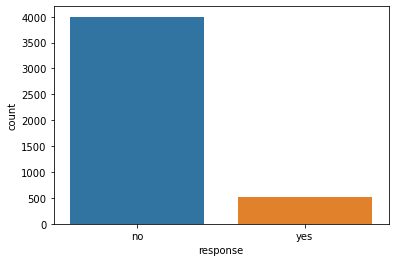

In [2]:
sns.countplot(imported_data.response)
#these are way unbalanced!

Text(0, 0.5, 'Proportion of Customers')

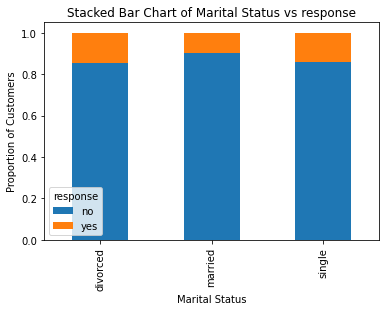

In [3]:
table=pd.crosstab(imported_data.marital,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs response')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')


Text(0, 0.5, 'Proportion of Customers')

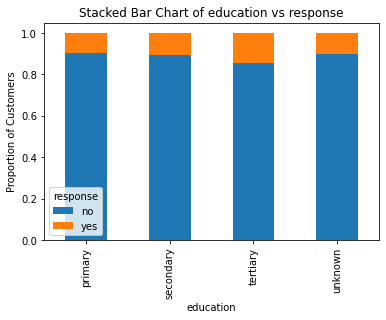

In [4]:
table=pd.crosstab(imported_data.education,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of education vs response')
plt.xlabel('education')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

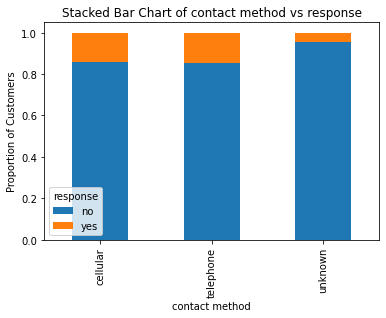

In [5]:
table=pd.crosstab(imported_data.contact,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of contact method vs response')
plt.xlabel('contact method')
plt.ylabel('Proportion of Customers')



Text(0, 0.5, 'Proportion of Customers')

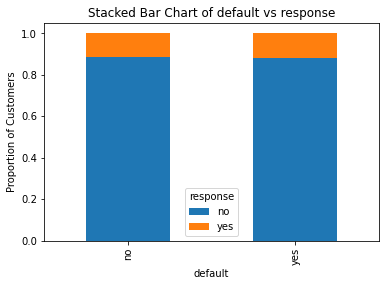

In [6]:
table=pd.crosstab(imported_data.default,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of default vs response')
plt.xlabel('default')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

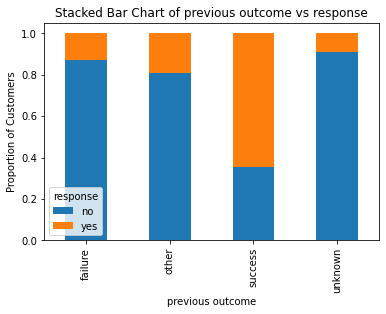

In [7]:
table=pd.crosstab(imported_data.poutcome,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of previous outcome vs response')
plt.xlabel('previous outcome')
plt.ylabel('Proportion of Customers')

In [8]:
#convert columns from y/n to 1/9
convert_to_binary = {'no' : 0, 'yes' : 1}

# define binary variable for having credit in default
default = imported_data['default'].map(convert_to_binary)
imported_data['default'] = default
# define binary variable for having a mortgage or housing loan
housing = imported_data['housing'].map(convert_to_binary)
imported_data['housing'] = housing
# define binary variable for having a personal loan
loan = imported_data['loan'].map(convert_to_binary)
imported_data['loan'] = loan
# define response variable to use in the model
response = imported_data['response'].map(convert_to_binary)
imported_data['response'] = response

display(imported_data.head())


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


In [9]:

df = imported_data.copy()


In [10]:
display(df.poutcome.value_counts())
display(df.contact.value_counts())
display(df.education.value_counts())
display(df.job.value_counts())
display(df.marital.value_counts())
display(df.poutcome.value_counts())

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64

cellular     2896
unknown      1324
telephone     301
Name: contact, dtype: int64

secondary    2306
tertiary     1350
primary       678
unknown       187
Name: education, dtype: int64

management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: job, dtype: int64

married     2797
single      1196
divorced     528
Name: marital, dtype: int64

unknown    3705
failure     490
other       197
success     129
Name: poutcome, dtype: int64

In [11]:
#poutcome != response
df[df.poutcome == 'success'].head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,response
49,61,admin.,married,unknown,0,4629,1,0,cellular,27,jan,181,1,92,1,success,1
70,37,management,married,tertiary,0,0,0,0,cellular,16,jul,268,2,182,3,success,1
98,36,blue-collar,divorced,secondary,0,2843,0,0,cellular,12,feb,473,1,182,1,success,0
110,21,student,single,secondary,0,2488,0,0,cellular,30,jun,258,6,169,3,success,1
156,55,admin.,married,secondary,0,602,0,0,cellular,1,jun,324,3,90,2,success,1


In [12]:
display(df.groupby(by='marital').agg(x= ('response', np.mean)))
display(df.groupby(by='contact').agg(x= ('response', np.mean)))
display(df.groupby(by='education').agg(x= ('response', np.mean)))
display(df.groupby(by='job').agg(x= ('response', np.mean)))

,x
marital,
divorced,0.145833
married,0.099035
single,0.139632


,x
contact,
cellular,0.143646
telephone,0.146179
unknown,0.046073


,x
education,
primary,0.094395
secondary,0.106245
tertiary,0.142963
unknown,0.101604


,x
job,
admin.,0.121339
blue-collar,0.072939
entrepreneur,0.089286
housemaid,0.125000
management,0.135191
retired,0.234783
self-employed,0.109290
services,0.091127
student,0.226190


In [13]:
#generates a binary response for married or not appends it to our dataframe
Married_Status = {'divorced' : 0, 'single' : 0, 'married' : 1}
married = df['marital'].map(Married_Status)
df['married'] = married

#generates a phone vs unknown binary response and appends to dataframe
Contact_Method = {'telephone' : 1, 'cellular' : 1, 'unknown' : 0}
phone = df['contact'].map(Contact_Method)
df['phone'] = phone

#generates a retried or not binary response column
df['retired'] = np.where(df['job'] == 'retired', 1 , 0)
#generates a student of not binary response column
df['student'] = np.where(df['job'] == 'student', 1 , 0)
#generates a p_outcome binary response column (previous marketing success)
df['p_outcome'] = np.where(df['poutcome'] == 'success', 1 , 0)

#drops columns from above contact, marital, poutcome now that we have a binary column for each
df.drop(['contact','marital', 'poutcome'], axis=1, inplace=True)

df.columns

Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'response',
       'married', 'phone', 'retired', 'student', 'p_outcome'],
      dtype='object')

Text(0, 0.5, 'Proportion of Customers')

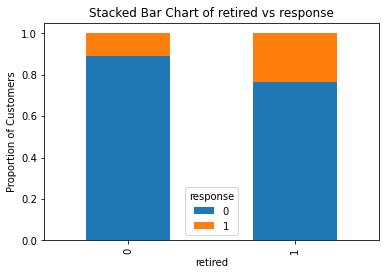

In [14]:

table=pd.crosstab(df.retired,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of retired vs response')
plt.xlabel('retired')
plt.ylabel('Proportion of Customers')


Text(0, 0.5, 'Proportion of Customers')

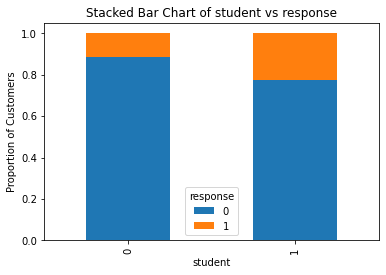

In [15]:
#there are a relatively small number of students <1% of the data. Likely should ignore this feature.
table=pd.crosstab(df.student,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of student vs response')
plt.xlabel('student')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

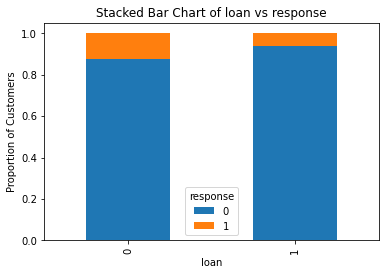

In [16]:
table=pd.crosstab(df.loan,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of loan vs response')
plt.xlabel('loan')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

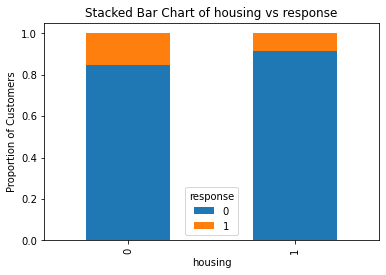

In [17]:
table=pd.crosstab(df.housing,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of housing vs response')
plt.xlabel('housing')
plt.ylabel('Proportion of Customers')

In [18]:
bank_df = df[['default', 'housing', 'loan', 'response']].copy()

In [19]:
#returns the proportion of positve responses
display(bank_df.groupby(by = default).agg(x= ('response', np.mean)))
display(bank_df.groupby(by = housing).agg(x= ('response', np.mean)))
display(bank_df.groupby(by = loan).agg(x= ('response', np.mean)))

,x
default,
0,0.115186
1,0.118421


,x
housing,
0,0.153415
1,0.085971


,x
loan,
0,0.124804
1,0.062229


# C. Regression Comparisons
## C1. Logistic Regression Classifier (default, housing, loan; to describe response; bank_df)

In [20]:
#split our train test out making sure we don't enrich our sets with one particular response
D_Train, D_Test = train_test_split(bank_df, test_size = 0.2, random_state = RANDOM_SEED, stratify = response)

#Train X and y
D_TrainY= D_Train['response'].copy()
D_TrainX= D_Train.drop('response', axis =1)

#Test X and y
D_TestY= D_Test['response'].copy()
D_TestX= D_Test.drop('response', axis =1)


<AxesSubplot:xlabel='response', ylabel='count'>

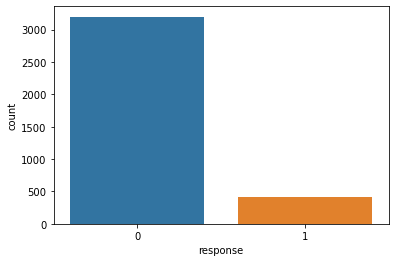

In [21]:
sns.countplot(D_Train.response)

<AxesSubplot:xlabel='response', ylabel='count'>

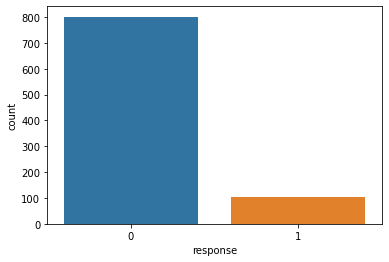

In [22]:
sns.countplot(D_Test.response)

In [23]:
#gets relative proportions of repsonses 
prop_1 = 1- D_Train.response.sum()/D_Train.shape[0]
prop_0 = 1-prop_1

In [24]:
prop_0

0.11532079646017701

In [25]:

Logreg_pipe = Pipeline([('regressor', LogisticRegression(class_weight = {0: prop_0, 1: prop_1}, random_state= RANDOM_SEED))])

#builds logistic regression pipeline
#Logreg_pipe = Pipeline([('regressor', LogisticRegression(class_weight = 'balanced', random_state= RANDOM_SEED))])
#fits logreg to out data
Logreg_pipe.fit(D_TrainX, D_TrainY)

#predict the labels from the train values
Logreg_train_pred = Logreg_pipe.predict_proba(D_TrainX)

Lt_preds = Logreg_pipe.predict(D_TrainX)

## ROC Curve for Training Set (Logistic Classifier; housing, loan, default)

Text(0.5, 1.0, 'ROC Curves for Logistic Regression (train)')

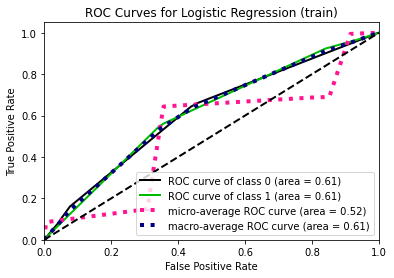

In [26]:


skplt.metrics.plot_roc_curve(D_TrainY, Logreg_train_pred )
plt.title('ROC Curves for Logistic Regression (train)')

## Confusion Matrix for Training Set (Logistic Classifier; housing, loan, default)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

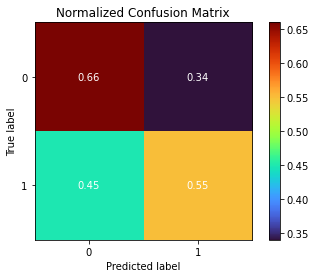

In [27]:
skplt.metrics.plot_confusion_matrix(D_TrainY, Lt_preds, normalize=True, cmap='turbo')


## Cross Validation  AUC score for Training Set (Logistic Classifier; housing, loan, default)

In [28]:
cv_results = cross_val_score(Logreg_pipe, D_TrainX, D_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.61327372 0.62827004 0.60070412 0.60689975 0.61818182 0.60271021
 0.54176909 0.66340951]


0.6094022839201889

## Precision Recall curve  for Training Set (Logistic Classifier; housing, loan, default)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

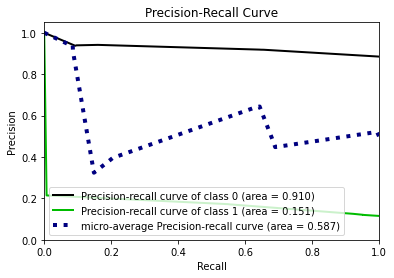

In [29]:
skplt.metrics.plot_precision_recall(D_TrainY, Logreg_train_pred)

## Logistic classifier performance with test hold-out

Text(0.5, 1.0, 'ROC Curves for Logistic Regression (test)')

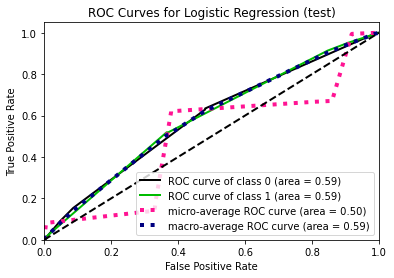

In [30]:

#predict the probabilities and labels from the test values
Logreg_test_pred = Logreg_pipe.predict_proba(D_TestX)
LogregTrain_pred = Logreg_pipe.predict(D_TestX)

skplt.metrics.plot_roc_curve(D_TestY, Logreg_test_pred )
plt.title('ROC Curves for Logistic Regression (test)')

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

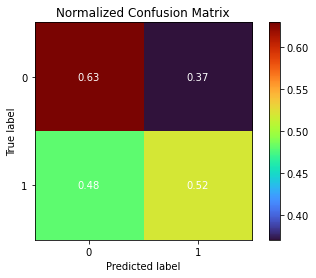

In [31]:
skplt.metrics.plot_confusion_matrix(D_TestY, LogregTrain_pred, normalize=True,cmap='turbo')

In [32]:
cv_results = cross_val_score(Logreg_pipe, D_TestX, D_TestY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.54493464 0.56461676 0.53787879 0.63786765 0.50937951 0.52660819
 0.62592593 0.655     ]


0.5752764317117065

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

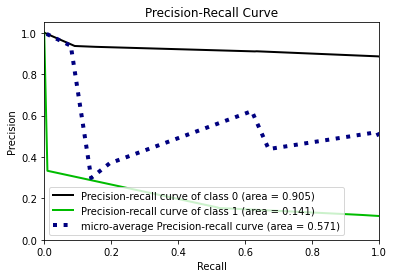

In [33]:
skplt.metrics.plot_precision_recall(D_TestY, Logreg_test_pred)

## C2. Naive Bayes Classifier (default, housing, loan; to describe response; bank_df)

### Pipeline Construction

In [34]:
BernoulliNB_pipe = Pipeline([('regressor', BernoulliNB(alpha=0.8, class_prior=[50, 50]))])
#fits logreg to out data
BernoulliNB_pipe.fit(D_TrainX, D_TrainY)

#predict the probablitiles and labels from the train values
BernoulliNB_train_pred = BernoulliNB_pipe.predict_proba(D_TrainX)
Bnb_train_preds = BernoulliNB_pipe.predict(D_TrainX)

## ROC curve  for Training Set (Naive Bayes Classifier; housing, loan, default)

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier (train)')

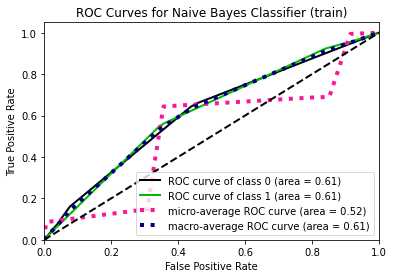

In [35]:
skplt.metrics.plot_roc_curve(D_TrainY, BernoulliNB_train_pred )
plt.title('ROC Curves for Naive Bayes Classifier (train)')

## Confusion matrix  for Training Set (Naive Bayes Classifier; housing, loan, default)

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

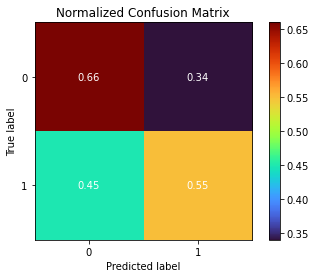

In [36]:
skplt.metrics.plot_confusion_matrix(D_TrainY, Bnb_train_preds, normalize=True, cmap='turbo')

## Cross Validation  AUC score for Training Set (Naive Bayes Classifier; housing, loan, default)

In [37]:
cv_results = cross_val_score(BernoulliNB_pipe, D_TrainX, D_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.61327372 0.62827004 0.60070412 0.6144802  0.61818182 0.60271021
 0.54176909 0.66340951]


0.6103498396132581

## Precision Recall curve  for Training Set (Naive Bayes Classifier; housing, loan, default)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

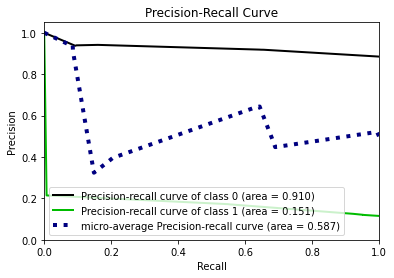

In [38]:
skplt.metrics.plot_precision_recall(D_TrainY, BernoulliNB_train_pred)

## Naive bayes performance with test hold out

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier')

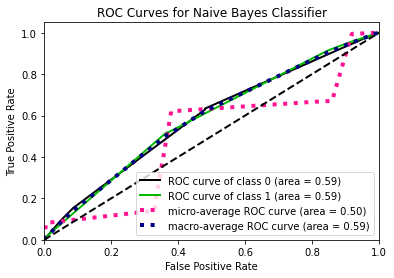

In [39]:
#predict the probabilities and labels from the test values
BernoulliNB_test_pred = BernoulliNB_pipe.predict_proba(D_TestX)
BernoulliNB_t_pred = BernoulliNB_pipe.predict(D_TestX)

skplt.metrics.plot_roc_curve(D_TestY, BernoulliNB_test_pred )
plt.title('ROC Curves for Naive Bayes Classifier')

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

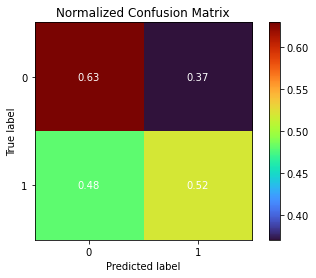

In [40]:
skplt.metrics.plot_confusion_matrix(D_TestY, BernoulliNB_t_pred, normalize=True, cmap='turbo')

In [41]:
cv_results = cross_val_score(BernoulliNB_pipe, D_TestX, D_TestY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.54003268 0.55659537 0.53787879 0.63786765 0.5007215  0.52660819
 0.67407407 0.64884615]


0.5778280494839125

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

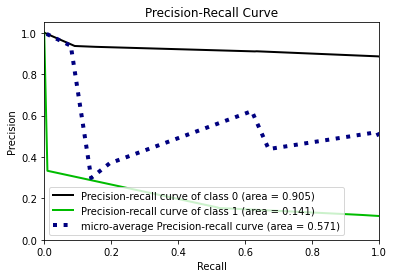

In [42]:
skplt.metrics.plot_precision_recall(D_TestY, BernoulliNB_test_pred)

### Cross tabulated summary counts for the model features

In [43]:
(pd.crosstab([bank_df['default'],bank_df['housing'],bank_df['loan']], [bank_df['response']], margins=True))

response                 0    1   All
default housing loan                 
0       0       0     1381  279  1660
                1      255   16   271
        1       0     1927  192  2119
                1      370   25   395
1       0       0       13    4    17
                1       12    2    14
        1       0       31    3    34
                1       11    0    11
All                   4000  521  4521

# D. Additional features (housing, loan, retired, p_outcome)


In [44]:
Expanded_bank= df[['housing', 'loan', 'retired', 'p_outcome','response']].copy()

In [45]:
E_Train, E_Test = train_test_split(Expanded_bank, test_size = 0.2, random_state = RANDOM_SEED, stratify = response)

#Train X and y
E_TrainY= E_Train['response'].copy()
E_TrainX= E_Train.drop('response', axis =1)

#Test X and y
E_TestY= E_Test['response'].copy()
E_TestX= E_Test.drop('response', axis =1)



In [46]:
Expanded_bank.columns

Index(['housing', 'loan', 'retired', 'p_outcome', 'response'], dtype='object')

## D1. Logistic Regression

In [47]:
Logreg_pipe.fit(E_TrainX, E_TrainY)

#predict the probabilities and labels from the train values
E_Logreg_train_pred = Logreg_pipe.predict_proba(E_TrainX)
ELogregtrain_preds = Logreg_pipe.predict(E_TrainX)

## ROC curve  for Training Set (Logistic Classifier; housing, loan, retired, p_outcome)

Text(0.5, 1.0, 'ROC Curves for Logistic Regression with additional features')

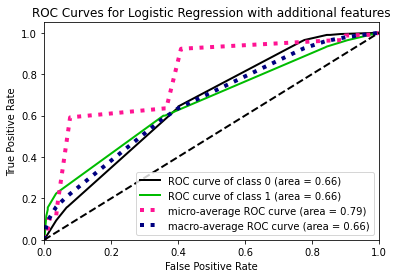

In [48]:
skplt.metrics.plot_roc_curve(E_TrainY, E_Logreg_train_pred )
plt.title('ROC Curves for Logistic Regression with additional features')

## Cross Validation AUC scores  for Training Set (Logistic Classifier; housing, loan, retired, p_outcome)

In [49]:
cv_results = cross_val_score(Logreg_pipe, E_TrainX, E_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.69964125 0.68858539 0.62674197 0.65604373 0.69388479 0.66758618
 0.56145685 0.7153927 ]


0.6636666072244648

## Precision Recall Curve for Training Set (Logistic Classifier; housing, loan, retired, p_outcome)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

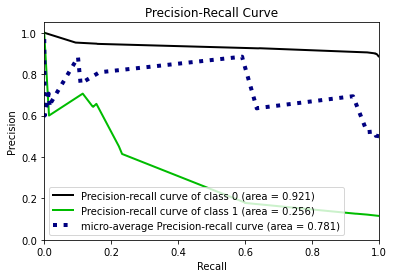

In [50]:
skplt.metrics.plot_precision_recall(E_TrainY, E_Logreg_train_pred)

## Confusion matrix for Training Set (Logistic Classifier; housing, loan, retired, p_outcome)

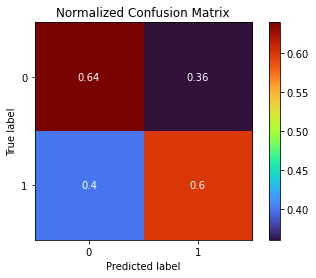

In [51]:
skplt.metrics.plot_confusion_matrix(E_TrainY, ELogregtrain_preds, normalize= True, cmap='turbo')
plt.show()

## D2. Naive Bayes Classification

In [52]:
#fits logreg to out data
BernoulliNB_pipe.fit(E_TrainX, E_TrainY)

#predict the probabilities and labels from the train values
EBernoulliNB_train_pred = BernoulliNB_pipe.predict_proba(E_TrainX)
EBernoulliNB_train_preds = BernoulliNB_pipe.predict(E_TrainX)

## ROC curve for Training Set (Naive Bayes Classifier; housing, loan, retired, p_outcome)

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier with additional features')

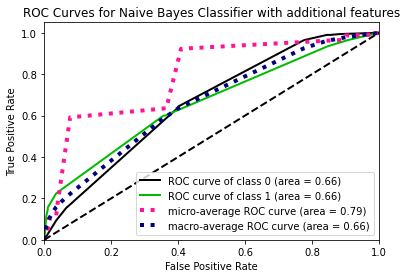

In [53]:
skplt.metrics.plot_roc_curve(E_TrainY, E_Logreg_train_pred )
plt.title('ROC Curves for Naive Bayes Classifier with additional features')

## Cross Validation AUC scores  for Training Set (Naive Bayes Classifier; housing, loan, retired, p_outcome)

In [54]:
cv_results = cross_val_score(BernoulliNB_pipe, E_TrainX, E_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.70949347 0.68858539 0.62131436 0.65351691 0.69049959 0.65268605
 0.55878294 0.712083  ]


0.6608702143603139

## Precision recall curves for Training Set (Naive Bayes Classifier; housing, loan, retired, p_outcome)

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

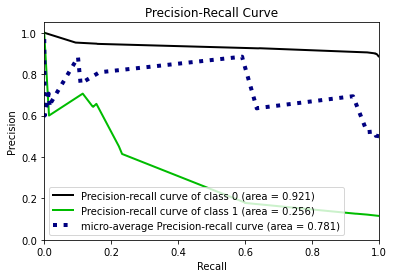

In [55]:
skplt.metrics.plot_precision_recall(E_TrainY , E_Logreg_train_pred )


## Confusion matrix for  Training Set (Naive Bayes Classifier; housing, loan, retired, p_outcome)

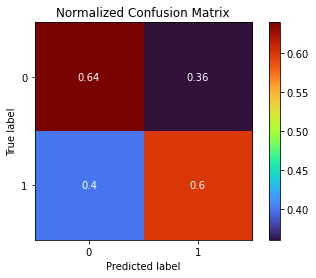

In [56]:
skplt.metrics.plot_confusion_matrix(E_TrainY, EBernoulliNB_train_preds, normalize= True, cmap='turbo')
plt.show()

### Cross tabulated counts for the model features

In [57]:
(pd.crosstab([Expanded_bank['housing'],Expanded_bank['loan'],Expanded_bank['retired'], Expanded_bank['p_outcome']], [Expanded_bank['response']], margins=True))

response                           0    1   All
housing loan retired p_outcome                 
0       0    0       0          1259  183  1442
                     1            20   54    74
             1       0           110   38   148
                     1             5    8    13
        1    0       0           248   16   264
                     1             1    1     2
             1       0            18    1    19
1       0    0       0          1907  173  2080
                     1            20   16    36
             1       0            31    6    37
        1    0       0           369   20   389
                     1             0    4     4
             1       0            12    1    13
All                             4000  521  4521

# E. Only Phone Method of Contact

In [58]:
df.columns

Index(['age', 'job', 'education', 'default', 'balance', 'housing', 'loan',
       'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'response',
       'married', 'phone', 'retired', 'student', 'p_outcome'],
      dtype='object')

In [59]:
phone_df = df.copy()

In [60]:
phone_df = phone_df[phone_df['phone']==1]


<AxesSubplot:xlabel='response', ylabel='count'>

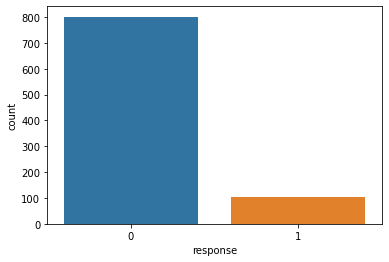

In [61]:
sns.countplot(D_Test.response)

Text(0, 0.5, 'Proportion of Customers')

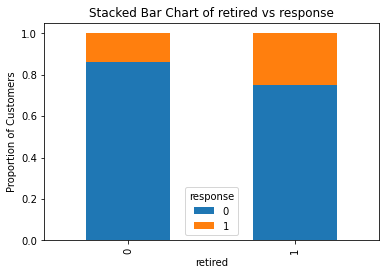

In [62]:
table=pd.crosstab(phone_df.retired,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of retired vs response')
plt.xlabel('retired')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

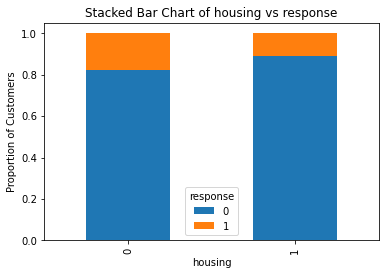

In [63]:
table=pd.crosstab(phone_df.housing,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of housing vs response')
plt.xlabel('housing')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

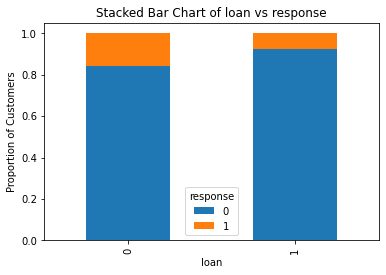

In [64]:
table=pd.crosstab(phone_df.loan,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of loan vs response')
plt.xlabel('loan')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

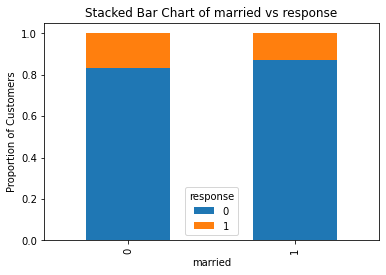

In [65]:
table=pd.crosstab(phone_df.married,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of married vs response')
plt.xlabel('married')
plt.ylabel('Proportion of Customers')

Text(0, 0.5, 'Proportion of Customers')

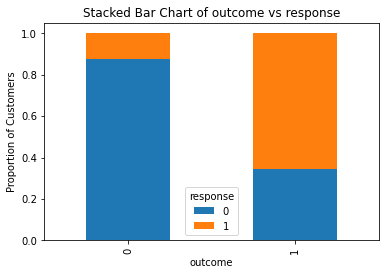

In [66]:
table=pd.crosstab(phone_df.p_outcome,imported_data.response)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of outcome vs response')
plt.xlabel('outcome')
plt.ylabel('Proportion of Customers')

In [67]:
phone_df

,age,job,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,response,married,phone,retired,student,p_outcome
0,30,unemployed,primary,0,1787,0,0,19,oct,79,1,-1,0,0,1,1,0,0,0
1,33,services,secondary,0,4789,1,1,11,may,220,1,339,4,0,1,1,0,0,0
2,35,management,tertiary,0,1350,1,0,16,apr,185,1,330,1,0,0,1,0,0,0
5,35,management,tertiary,0,747,0,0,23,feb,141,2,176,3,0,0,1,0,0,0
6,36,self-employed,tertiary,0,307,1,0,14,may,341,1,330,2,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,32,services,secondary,0,473,1,0,7,jul,624,5,-1,0,0,0,1,0,0,0
4516,33,services,secondary,0,-333,1,0,30,jul,329,5,-1,0,0,1,1,0,0,0
4518,57,technician,secondary,0,295,0,0,19,aug,151,11,-1,0,0,1,1,0,0,0
4519,28,blue-collar,secondary,0,1137,0,0,6,feb,129,4,211,3,0,1,1,0,0,0


In [68]:
phone_bank= phone_df.copy()

phone_bank = phone_bank[['housing', 'loan', 'retired', 'p_outcome','response']]

In [69]:
phone_bank


,housing,loan,retired,p_outcome,response
0,0,0,0,0,0
1,1,1,0,0,0
2,1,0,0,0,0
5,0,0,0,0,0
6,1,0,0,0,0
...,...,...,...,...,...
4515,1,0,0,0,0
4516,1,0,0,0,0
4518,0,0,0,0,0
4519,0,0,0,0,0


In [70]:

P_Train, P_Test = train_test_split(phone_bank, test_size = 0.2, random_state = RANDOM_SEED)

#Train X and y
P_TrainY= P_Train['response'].copy()
P_TrainX= P_Train.drop('response', axis =1)

#Test X and y
P_TestY= P_Test['response'].copy()
P_TestX= P_Test.drop('response', axis =1)

<AxesSubplot:xlabel='response', ylabel='count'>

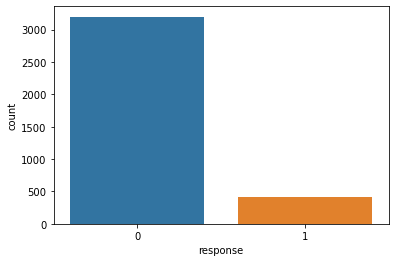

In [71]:
sns.countplot(D_Train.response)

## Logistic Regression for only customers contacted via phone

In [72]:
Logreg_pipe.fit(P_TrainX, P_TrainY)

#predict the labels from the train values
P_Logreg_train_pred = Logreg_pipe.predict_proba(P_TrainX)
PL_logreg_train_pred = Logreg_pipe.predict(P_TrainX)

Text(0.5, 1.0, 'ROC Curves for Logistic Regression with additional features for phone contacts')

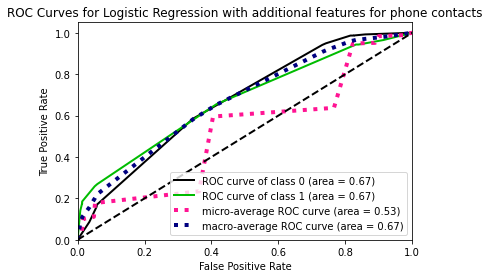

In [73]:
skplt.metrics.plot_roc_curve(P_TrainY, P_Logreg_train_pred )
plt.title('ROC Curves for Logistic Regression with additional features for phone contacts')

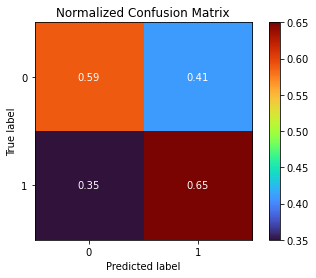

In [74]:
skplt.metrics.plot_confusion_matrix(P_TrainY, PL_logreg_train_pred, normalize= True, cmap='turbo')
plt.show()

In [75]:
cv_results = cross_val_score(Logreg_pipe, P_TrainX, P_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.65056526 0.72844444 0.67359197 0.61915152 0.73496296 0.68631897
 0.63682796 0.63045455]


0.6700397039263506

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

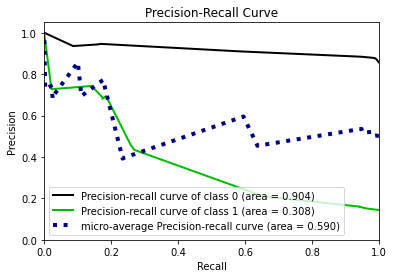

In [76]:
skplt.metrics.plot_precision_recall(P_TrainY, P_Logreg_train_pred)

### Evaluation of logistic classifier with test hold out

Text(0.5, 1.0, 'ROC Curves for Logistic Regression with additional features for phone contacts')

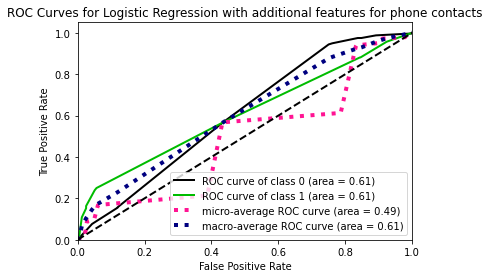

In [77]:
P_Logreg_test_pred = Logreg_pipe.predict_proba(P_TestX)

skplt.metrics.plot_roc_curve(P_TestY, P_Logreg_test_pred )
plt.title('ROC Curves for Logistic Regression with additional features for phone contacts')

In [78]:
cv_results = cross_val_score(Logreg_pipe, P_TestX, P_TestY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.70895522 0.63504611 0.485      0.54347826 0.62391775 0.62847222
 0.60079051 0.56655844]


0.5990273155736938

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

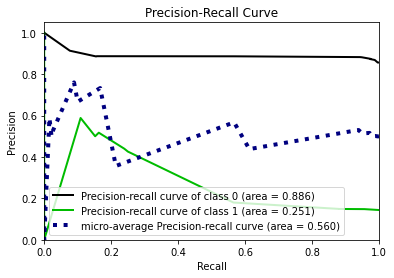

In [79]:
skplt.metrics.plot_precision_recall(P_TestY, P_Logreg_test_pred)

## Naive Bayes Classifier for only customers contacted via phone

In [80]:
#fits logreg to out data
BernoulliNB_pipe.fit(P_TrainX, P_TrainY)

#predict the labels from the train values
PBernoulliNB_train_pred = BernoulliNB_pipe.predict_proba(P_TrainX)
PL_NB_train_pred = BernoulliNB_pipe.predict(P_TrainX)

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier with additional features')

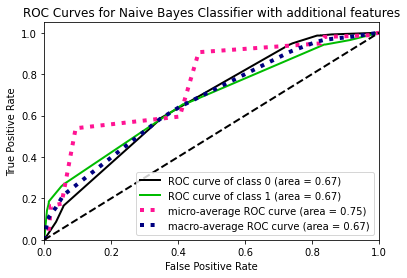

In [81]:
skplt.metrics.plot_roc_curve(P_TrainY, PBernoulliNB_train_pred )
plt.title('ROC Curves for Naive Bayes Classifier with additional features')


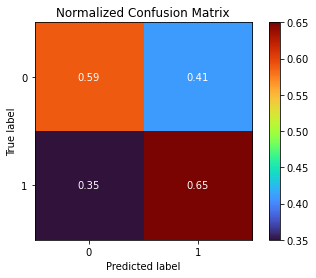

In [82]:
skplt.metrics.plot_confusion_matrix(P_TrainY, PL_NB_train_pred, normalize= True, cmap='turbo')
plt.show()

In [83]:
cv_results = cross_val_score(BernoulliNB_pipe, P_TrainX, P_TrainY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.65056526 0.72787879 0.67359197 0.61818182 0.73496296 0.68631897
 0.63387097 0.63045455]


0.6694781610785173

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

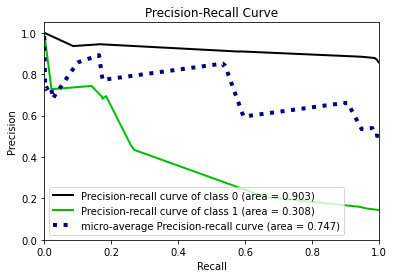

In [84]:
skplt.metrics.plot_precision_recall(P_TrainY, PBernoulliNB_train_pred)

### Evaluation of naive bayes classifier with test hold out

Text(0.5, 1.0, 'ROC Curves for Naive Bayes Classifier with additional features')

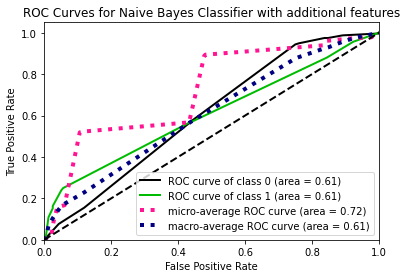

In [85]:
PBernoulliNB_test_pred = BernoulliNB_pipe.predict_proba(P_TestX)
skplt.metrics.plot_roc_curve(P_TestY, PBernoulliNB_test_pred )
plt.title('ROC Curves for Naive Bayes Classifier with additional features')


In [86]:
cv_results = cross_val_score(BernoulliNB_pipe, P_TestX, P_TestY, cv=kfold, scoring= 'roc_auc')
print(cv_results)
np.mean(cv_results)

[0.70895522 0.69960474 0.485      0.54347826 0.62391775 0.62847222
 0.60079051 0.56655844]


0.6070971442956963

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

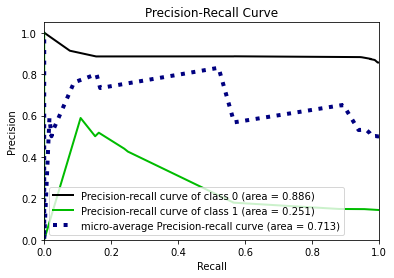

In [87]:
skplt.metrics.plot_precision_recall(P_TestY, PBernoulliNB_test_pred)

In [88]:
(pd.crosstab([phone_bank['housing'],phone_bank['loan'],phone_bank['retired'], phone_bank['p_outcome']], [phone_bank['response']], margins=True))

response                           0    1   All
housing loan retired p_outcome                 
0       0    0       0           985  171  1156
                     1            20   54    74
             1       0            96   34   130
                     1             5    8    13
        1    0       0           205   15   220
                     1             1    1     2
             1       0            12    0    12
1       0    0       0          1137  135  1272
                     1            18   16    34
             1       0            20    5    25
        1    0       0           231   17   248
                     1             0    4     4
             1       0             7    0     7
All                             2737  460  3197